# ACLED National and Subnational Conflict Trends

In [38]:
%reload_ext autoreload
%autoreload 2

import os
import pandas as pd

from acled_conflict_analysis import visuals
from acled_conflict_analysis import processing
from acled_conflict_analysis import extraction


from bokeh.plotting import show, output_notebook
from bokeh.layouts import column
import bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.models import Panel, Tabs, TabPanel

from datetime import date
from datetime import datetime

In [39]:
from acled_visuals import *

In [40]:
countries_of_interest = ["Ethiopia"]
START_DATE = "2012-01-01"
END_DATE = datetime.today().strftime('%Y-%m-%d')

In [41]:
os.environ['ACLED_EMAIL'] = extraction.get_acled_credentials()[0]
os.environ['ACLED_KEY'] = extraction.get_acled_credentials()[1]

In [42]:
# data = extraction.acled_api(
#     # email_address=os.environ.get("ACLED_EMAIL"),
#     # access_key=os.environ.get("ACLED_KEY"),
#     countries=countries_of_interest,
#     start_date=START_DATE,
#     end_date=END_DATE
# )


In [43]:
data = pd.read_csv('../../data/conflict/acled_raw_20250925.csv')


In [44]:
extracted_date = datetime.today().strftime('%Y%m%d')
processing.data_type_conversion(data)

In [45]:
import calendar


last_date = data['event_date'].max()
last_date = last_date.strftime('%d %b %Y')
# extracted_date_formatted = datetime.today().strftime('%d %b %Y')
# last_date = last_date.strftime('%d %B %Y')
extracted_date_formatted = datetime.today().strftime('%d %B %Y')

In [46]:
#data.to_csv(f'../../data/conflict/acled_raw_{extracted_date}.csv')

In [47]:
conflict_monthly = processing.get_acled_by_group(data, columns=['latitude', 'longitude'], freq='MS')
conflict_yearly = processing.get_acled_by_group(data, columns=['latitude', 'longitude'], freq='YS')
conflict_yearly_national = processing.get_acled_by_group(data, columns=['country'], freq='YS')
conflict_sub_event_type = processing.get_acled_by_group(data, columns = ['event_type', 'sub_event_type'], freq='QS')
conflict_event_type = processing.get_acled_by_group(data, columns = ['country','event_type'], freq='QS')

conflict_quarterly = processing.get_acled_by_group(data, columns=['latitude', 'longitude'], freq='QS')
conflict_quarterly_national = processing.get_acled_by_group(data, columns=['country'], freq='QS')

In [83]:
events_dict = {datetime(2020, 11, 2):'Start of the Tigray War',
               #datetime(2022,3,29):'North Shewa Clashes',
    #datetime(2022, 11, 22):'Peace Agreement between \n  Ethiopia and TPLF',
    datetime(2023,4,9 ):'Start of the Amhara War'
               }

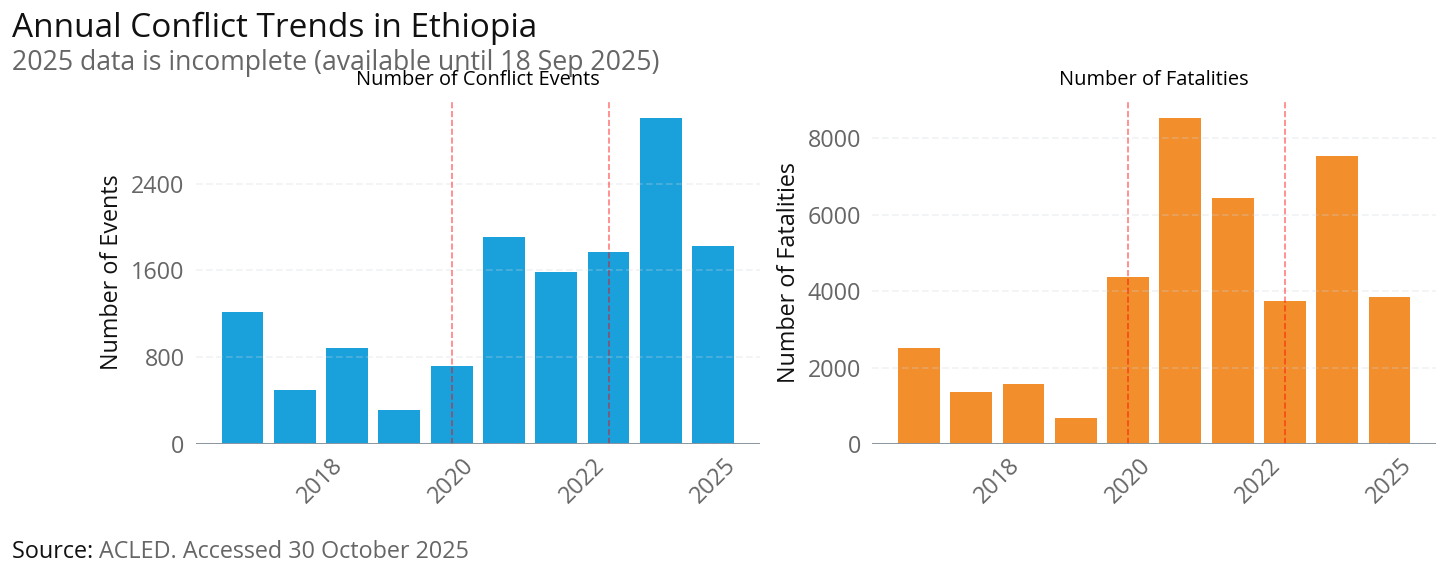

In [101]:
# Create the World Bank styled plots
from acled_visuals import *
plot_conflict_trends_wb(conflict_yearly_national, events_dict, extracted_date_formatted, last_date, figsize=(1600,600))

In [52]:
ethiopia_adm1 = gpd.read_file('../../data/boundaries/Region_14/Regions_14.shp')
ethiopia_adm2 = gpd.read_file('../../boundaries/adm2_mapped.geojson')
ethiopia_adm3 = gpd.read_file('../../boundaries/adm3_mapped.geojson')

In [53]:
conflict_monthly_regional = processing.get_acled_by_admin(ethiopia_adm1, data, ['ADM1_EN'], freq='MS') 
conflict_yearly_regional = processing.get_acled_by_admin(ethiopia_adm1, data, ['ADM1_EN'], freq='YS') 

In [54]:
top5 = list(conflict_monthly_regional.groupby('ADM1_EN')['nrFatalities'].sum().reset_index().sort_values(by='nrFatalities',ascending=False).head(5)['ADM1_EN'])
top5

['Oromia', 'Amhara', 'Tigray', 'Benishangul Gumz', 'Somali']

In [55]:
# output_file("bokeh_plot.html")
from bokeh.io import output_file, show
output_file("bokeh_plot.html")
output_notebook()
#from acled_visuals import get_line_plot

tabs = []
labels = {"nrFatalities": "Number of Fatalities","nrEvents": "Number of Events"}
df = conflict_yearly_regional[(conflict_yearly_regional['ADM1_EN'].isin(top5))
                              &(conflict_yearly_regional['event_date']>'2016-01-01')].copy()

for idx, type in enumerate(["nrFatalities", "nrEvents"]):
    tabs.append(
        TabPanel(
            child=visuals.get_line_plot(
                df,
                f"{labels[type]} in Regions (Highest Impact)",
                #f"Figure shows annual total fatalities and conflict events, 2025 is incomplete and only available until {last_date}. \nSource: ACLED. Accessed {extracted_date_formatted}.",
                source=f"Source: ACLED. Accessed {extracted_date_formatted}",
                category="ADM1_EN",
                measure=type,
                events_dict = events_dict,
                plot_height=450,
                plot_width = 700
            ),
            title=type.capitalize(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [56]:
# output_file("bokeh_plot.html")
output_notebook()

df = conflict_quarterly_national[conflict_quarterly_national['event_date']>'2016-01-01'].copy()

tabs = []
labels = {"nrFatalities": "Number of Fatalities","nrEvents": "Number of Events"}

for idx, type in enumerate(["nrFatalities", "nrEvents"]):
    tabs.append(
        TabPanel(
            child=visuals.get_line_plot(
                df,
                f"National Quarterly Trends in {labels[type]}",
                f"Figure shows annual total fatalities and conflict events, 2025 is incomplete and only available until {last_date}. \nSource: ACLED. Accessed {extracted_date_formatted}.",
                #source=f"ACLED. Accessed on {extracted_date_formatted}",
                category="country",
                measure=type,
                events_dict = events_dict,
                plot_width=750,
                plot_height=300
            ),
            title=type.capitalize(),    
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

## Spatial Distribution of Conflict

In [57]:
import geopandas as gpd
ethiopia_adm0 = gpd.read_file('../../data/boundaries/eth_admbnda_adm0_csa_bofedb_itos_2021.shp')
eth_h3 = processing.convert_to_h3_grid(ethiopia_adm0, resolution=5)

In [58]:
import pandas as pd
from datetime import datetime

def get_category(event_date):
    """
    Categorize events based on date ranges.
    
    Parameters:
    -----------
    event_date : datetime, pandas.Timestamp, or str
        The date of the event
        
    Returns:
    --------
    str
        The category of the event based on the date
    """
    # Convert string date to pandas Timestamp if it's not already
    if isinstance(event_date, str):
        event_date = pd.Timestamp(event_date)
    # Convert datetime to pandas Timestamp if it's not already
    elif isinstance(event_date, datetime):
        event_date = pd.Timestamp(event_date)
    
    # Make sure event_date is a pandas Timestamp
    if not isinstance(event_date, pd.Timestamp):
        raise TypeError("event_date must be a datetime, pandas.Timestamp, or string date")
    
    # Define the date range boundaries
    tigray_start = pd.Timestamp('2020-11-03')
    tigray_end = pd.Timestamp('2022-11-03')
    amhara_start = pd.Timestamp('2023-04-01')
    
    # Compare using proper timestamp comparison
    if tigray_start <= event_date <= tigray_end:
        return 'Tigray War (3rd Nov 2020 - 3rd Nov 2022)'
    elif event_date >= amhara_start:
        return f'Amhara War (1st Apr 2023 - {last_date})'

In [59]:
category_list = ['Tigray War (3rd Nov 2020 - 3rd Nov 2022)', f'Amhara War (1st Apr 2023 - {last_date})']

In [60]:
data['category'] = data['event_date'].apply(lambda x: get_category(x))
df = data[~(data['category'].isna())]

In [61]:
import numpy as np
conflict_monthly_h3 = processing.get_acled_by_admin(eth_h3, df, columns=['h3_index', 'category'], freq='MS', fatalities='fatalities')
conflict_monthly_h3.drop(columns=['index'], inplace=True)

conflict_monthly_h3['conflict_intensity_index_op1'] = np.sqrt((conflict_monthly_h3['nrEvents']) * 
                                           (conflict_monthly_h3['nrFatalities'] + 1))

conflict_monthly_h3 = conflict_monthly_h3.groupby(['h3_index', 'category'])[['nrEvents', 'nrFatalities', 'conflict_intensity_index_op1']].mean().reset_index()
conflict_monthly_h3 = eth_h3.merge(conflict_monthly_h3, on='h3_index', how='inner')

In [62]:
# fig, ax = visuals.plot_h3_maps_by_column_value(conflict_monthly_h3, 
#                                 title='Mean Conflict Index per Month',
#                                 measure='conflict_intensity_index_op1',
#                                 column_name='category',
#                                 boundary_gdfs_map = {category_list[0]: ethiopia_adm1, category_list[1]: ethiopia_adm2},
#                                 subtitle_prefix =''
#                                #figsize=(10,5)
#                                 )

In [63]:
conflict_monthly_h3.to_file(f'../../data/conflict/acled_monthly_conflict_{extracted_date}.shp')

/var/folders/gs/_227cnyd0pq1fr817_0jbcyw0000gp/T/ipykernel_20188/2207045654.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  conflict_monthly_h3.to_file(f'../../data/conflict/acled_monthly_conflict_{extracted_date}.shp')
/Users/ssarva/Library/CloudStorage/OneDrive-WBG/Documents/ethiopia-economic-monitoring/.venv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'nrFatalities' to 'nrFataliti'
  ogr_write(
/Users/ssarva/Library/CloudStorage/OneDrive-WBG/Documents/ethiopia-economic-monitoring/.venv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'conflict_intensity_index_op1' to 'conflict_i'
  ogr_write(


## Conflict Intensity Index

The Conflict Intensity Index is calculated using the following formula:

**Conflict Intensity Index = √(Number of Events × (Number of Fatalities + 1))**

Where:
- **Number of Events**: Total count of conflict events in the given time period and location
- **Number of Fatalities**: Total number of fatalities from conflict events (adding 1 to avoid zero multiplication)
- The square root is applied to normalize the scale and reduce the impact of extreme values

This index provides a composite measure that accounts for both the frequency of conflicts (events) and their severity (fatalities), giving higher weight to areas with both frequent and deadly conflicts.

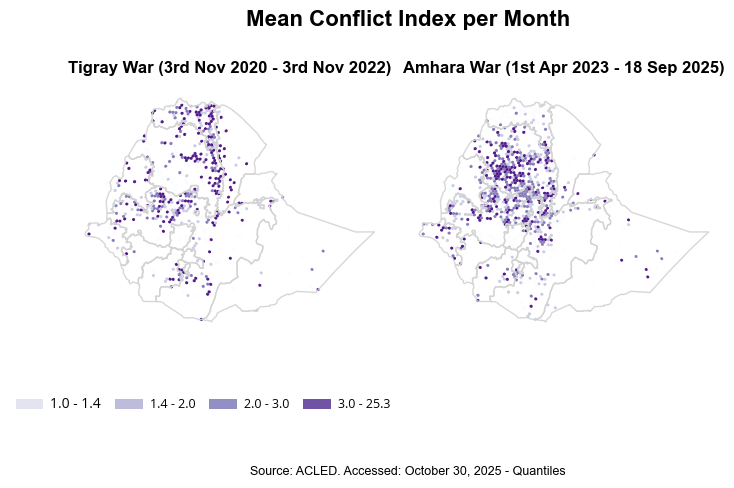

In [64]:
fig, ax = create_comparative_maps(conflict_monthly_h3, 
                                title='Mean Conflict Index per Month',
                                measures={'conflict_intensity_index_op1': {'label_name':'', 'alpha':0.9}},
                                aggregation='h3',
                                categories=category_list,
                                boundary_gdf=ethiopia_adm1,
                               figsize=(9,5),
                               layout='columns',
                               binning_method='quantile'
                                );

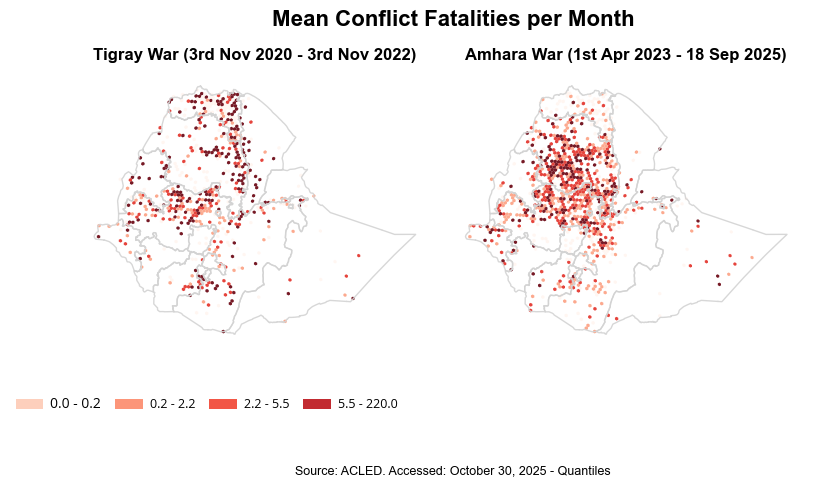

In [65]:

fig, ax = create_comparative_maps(conflict_monthly_h3, 
                                title='Mean Conflict Fatalities per Month',
                                measures={'nrFatalities': {'label_name':'', 'alpha':0.9}},
                                aggregation='h3',
                                categories=category_list,
                                boundary_gdf=ethiopia_adm1,
                               figsize=(10,5),
                               binning_method='quantile'
                                )

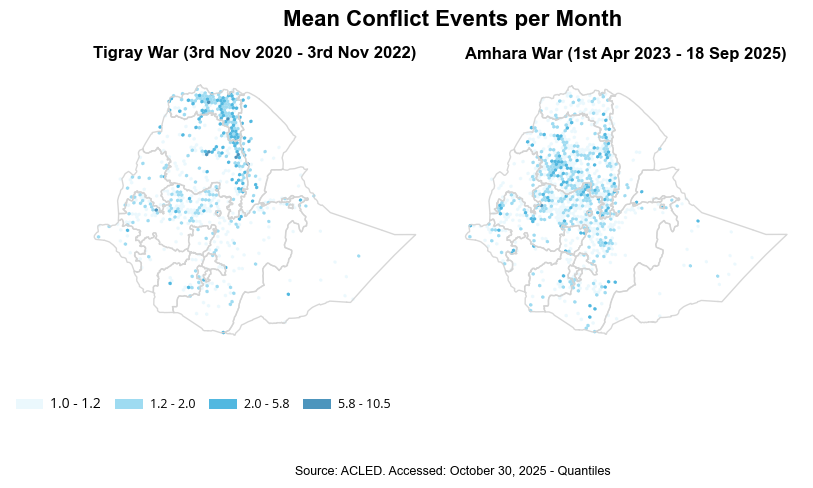

In [66]:
fig, ax = create_comparative_maps(conflict_monthly_h3, 
                                title='Mean Conflict Events per Month',
                                measures={'nrEvents': {'label_name':None}},
                                aggregation='h3',
                                categories=category_list,
                                boundary_gdf=ethiopia_adm1,
                               figsize=(10,5),
                               #cmaps='viridis',
                               binning_method='quantile'
                                )

In [67]:
data.rename(columns={'fatalities':'nrFatalities'}, inplace=True)

In [68]:
from bokeh.plotting import show, output_notebook
import bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.models import Panel, Tabs

output_notebook()

bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

measure_names = {
    "nrEvents": "Number of Conflict Events",
    "nrFatalities": "Number of Fatalities",
}
measure_colors = {"nrEvents": "#4E79A7", "nrFatalities": "#F28E2B"}

measure = 'nrFatalities'

show(
    visuals.get_bar_chart(
        conflict_monthly,
        f"Monthly Reported {measure_names[measure]}",
        f"Source: ACLED. Accessed date {extracted_date_formatted}",
        subtitle="",
        category=None,
        measure=measure,
        color_code=measure_colors[measure],
        events_dict=events_dict
    )
)

Loading BokehJS ...

In [69]:
from bokeh.plotting import show, output_notebook
import bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.models import Panel, Tabs, TabPanel

output_notebook()

bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)


tabs = []
measure_names = {
    "nrEvents": "Number of Conflict Events",
    "nrFatalities": "Number of Fatalities",
}
measure_colors = {"nrEvents": "#4E79A7", "nrFatalities": "#F28E2B"}
# acled_adm0 = get_acled_by_admin(syria_adm2_crs, acled, columns = ['ADM2_EN', 'ADM1_EN'])
for category_type in list(conflict_event_type["event_type"].unique()):
    tabs.append(
        TabPanel(
            child=visuals.get_bar_chart(
                conflict_event_type,
                f"Quarterly Conflict Events - {category_type}",
                f"Source: ACLED. Accessed date {extracted_date_formatted}",
                subtitle="",
                category="event_type",
                measure="nrEvents",
                color_code=measure_colors["nrEvents"],
                category_value=category_type,
                #events_dict=events_dict
            ),
            title=category_type.title(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [70]:
output_notebook()
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.models import Panel, Tabs
from bokeh.palettes import Category10  # Import Bokeh color palette
import random


bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

for category_type in list(conflict_sub_event_type["event_type"].unique()):

    df = conflict_sub_event_type[
                    conflict_sub_event_type["event_type"] == category_type
                ]
    event_types = list(df["sub_event_type"].unique())

    num_event_types = len(df["sub_event_type"].unique())
    if num_event_types < 10:
        # If there are fewer than 10 event types, randomly pick that many colors from Category10[10]
        colors = random.sample(Category10[10], num_event_types)
    else:
        # If there are 10 or more event types, use Category10[10] directly
        colors = Category10[10]

    tabs.append(
        TabPanel(
            child=visuals.get_stacked_bar_chart(
                df,
                f"Quarterly Conflict Events by Sub Type",
                source_text=f"Source: ACLED. Accessed {extracted_date_formatted}",
                date_column="event_date",
                categories=event_types,
                measure="nrEvents",
                category_column='sub_event_type',
                colors=colors,
                events_dict=events_dict,
            ),
            title=category_type.title(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [71]:
conflict_adm1_monthly = processing.get_acled_by_admin(ethiopia_adm1, data, columns=['ADM1_EN'], freq='MS', fatalities='nrFatalities')
conflict_adm1_annual = processing.get_acled_by_admin(ethiopia_adm1, data, columns=['ADM1_EN'], freq='YS', fatalities='nrFatalities')
conflict_adm1_quarterly = processing.get_acled_by_admin(ethiopia_adm1, data, columns=['ADM1_EN'], freq='QS', fatalities='nrFatalities')

/var/folders/gs/_227cnyd0pq1fr817_0jbcyw0000gp/T/ipykernel_20188/1374347150.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  subplot_ax.set_xticklabels(all_years, rotation=45, fontsize=8)
/var/folders/gs/_227cnyd0pq1fr817_0jbcyw0000gp/T/ipykernel_20188/1374347150.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  subplot_ax.set_xticklabels(all_years, rotation=45, fontsize=8)
/var/folders/gs/_227cnyd0pq1fr817_0jbcyw0000gp/T/ipykernel_20188/1374347150.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  subplot_ax.set_xticklabels(all_years, rotation=45, fontsize=8)
/var/folders/gs/_227cnyd0pq1fr817_0jbcyw0000gp/T/ipykernel_20188/1374347150.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. afte

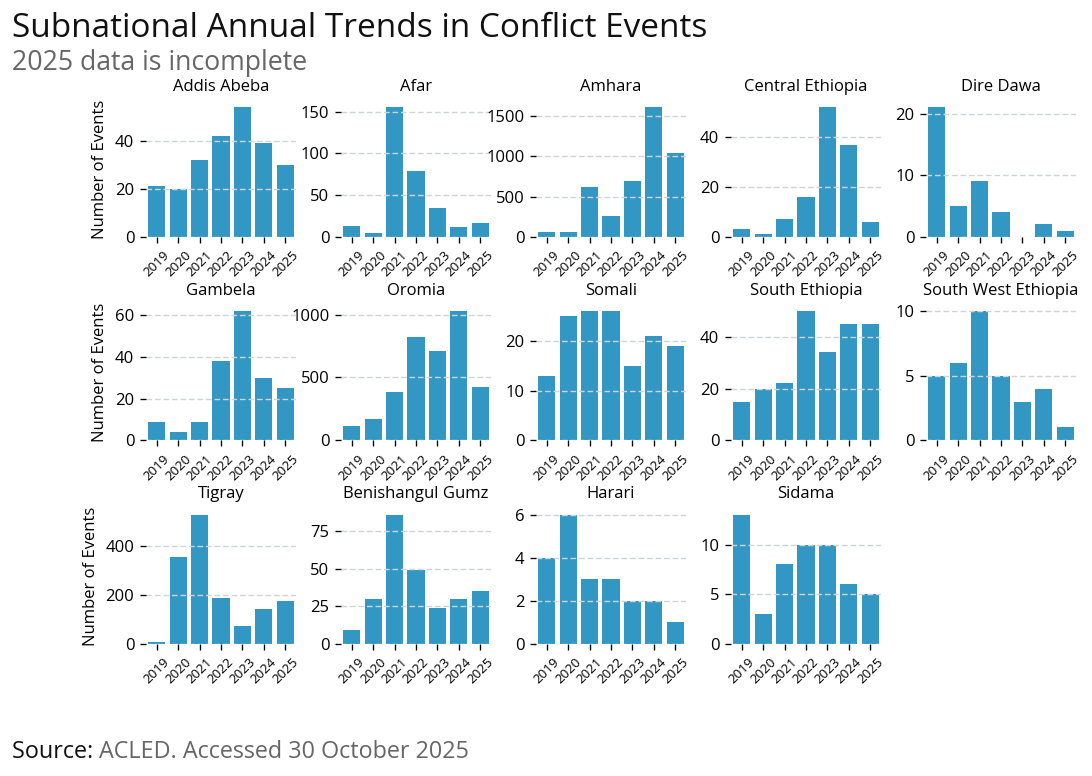

In [72]:
from wbpyplot import wb_plot
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import rcParams

# Based on the documentation at https://worldbank.github.io/wbpyplot/reference/wb_plot.html
@wb_plot(
    title="Subnational Annual Trends in Conflict Events", 
    subtitle="2025 data is incomplete",
    note=[("Source:", f"ACLED. Accessed {extracted_date_formatted}")],
    width=1200,
    height=800,
    nrows=1,  # Explicitly request one row
    ncols=1,  # And one column
)
def regional_conflict_plot(ax):
    """Create a multi-panel figure showing regional conflict trends.
    
    Args:
        ax: Axes object or list provided by the decorator
        
    Returns:
        fig: The completed figure
    """
    # Handle case when ax is a list
    if isinstance(ax, list):
        main_ax = ax[0]  # Get the first axes
    else:
        main_ax = ax
        
    # Get the figure from the decorator-provided axes
    fig = main_ax.figure
    
    # Hide the original axes since we'll create our own grid
    main_ax.set_visible(False)
    
    # Get regions to determine grid dimensions
    regions = list(conflict_adm1_annual['ADM1_EN'].unique())
    n_regions = len(regions)
    n_cols = 5
    n_rows = math.ceil(n_regions / n_cols)
    
    # Create a grid of subplots within the existing figure
    from matplotlib.gridspec import GridSpec
    gs = GridSpec(n_rows, n_cols, figure=fig)
    
    # First determine the common x-axis years (2019-2025)
    all_years = list(range(2019, 2026))
    
    # Plot each region
    for i, region in enumerate(regions):
        if i >= n_regions:
            break
            
        # Create a subplot within the existing figure
        subplot_ax = fig.add_subplot(gs[i])
        
        # Get data for this region
        df = conflict_adm1_annual[conflict_adm1_annual['ADM1_EN'] == region].copy()
        df = df[df['event_date'] >= '2019-01-01']
        
        if df.empty:
            subplot_ax.set_title(f"{region} (no data)", fontsize=10)
            subplot_ax.set_axis_off()
            continue
            
        # Extract year and prepare data for plotting
        df = df.sort_values('event_date').reset_index(drop=True)
        
        # Convert event_date to datetime if it's not already
        if not pd.api.types.is_datetime64_any_dtype(df['event_date']):
            df['event_date'] = pd.to_datetime(df['event_date'])
            
        # Add year column for better x-labels
        df['year'] = df['event_date'].dt.year
        
        # Create a complete dataframe with all years, filling missing years with 0
        year_data = pd.DataFrame({'year': all_years})
        df_plot = year_data.merge(df[['year', 'nrEvents']], on='year', how='left').fillna(0)

        # Plot data with year on x-axis
        sns.barplot(data=df_plot, x='year', y='nrEvents', color='#1AA1DB', ax=subplot_ax)
        
        # Format axis
        subplot_ax.set_title(region, fontsize=10)
        subplot_ax.set_xticklabels(all_years, rotation=45, fontsize=8)
        
        # Set consistent y-axis limits based on the subplot's position
        if i % n_cols == 0:
            subplot_ax.set_ylabel('Number of Events')
        else:
            subplot_ax.set_ylabel('')
            
        subplot_ax.set_xlabel('')
        subplot_ax.spines['top'].set_visible(False)
        subplot_ax.spines['right'].set_visible(False)
    
    # Adjust layout spacing - leave more space at top for the title
    fig.subplots_adjust(hspace=0.5, wspace=0.3, top=0.85)
    
    return fig

# Run the function to create the visualization
regional_conflict_plot()

## Population living in the same regions as conflict

In [87]:
#data.drop(columns=['Unnamed: 0'], inplace=True)

In [88]:
import mercantile
def get_quadkey_from_lat_lon(lat, lon, zoom=12):
    
    tile = mercantile.tile(lon, lat, zoom)
    quadkey = mercantile.quadkey(tile)
    return quadkey

In [89]:
data['quad13'] = data.apply(lambda row: get_quadkey_from_lat_lon(row['latitude'], row['longitude'], zoom=13), axis=1)

In [90]:
data['nrEvents'] = 1

In [91]:
conflict_quad13 = data.groupby(['quad13', 'category'])[['nrFatalities','nrEvents']].sum().reset_index()
conflict_quad13['category'].unique()

array(['Amhara War (1st Apr 2023 - 18 Sep 2025)',
       'Tigray War (3rd Nov 2020 - 3rd Nov 2022)'], dtype=object)

In [92]:
affected_quad_tigray = conflict_quad13[conflict_quad13['category'] == 'Tigray War (3rd Nov 2020 - 3rd Nov 2022)']['quad13'].unique()
affected_quad_amhara = conflict_quad13[conflict_quad13['category'] == f'Amhara War (1st Apr 2023 - {last_date})']['quad13'].unique()

In [93]:
eth_worldpop = gpd.read_file('../../data/population/gdf_ETH.gpkg')
total_population = eth_worldpop['population'].sum()

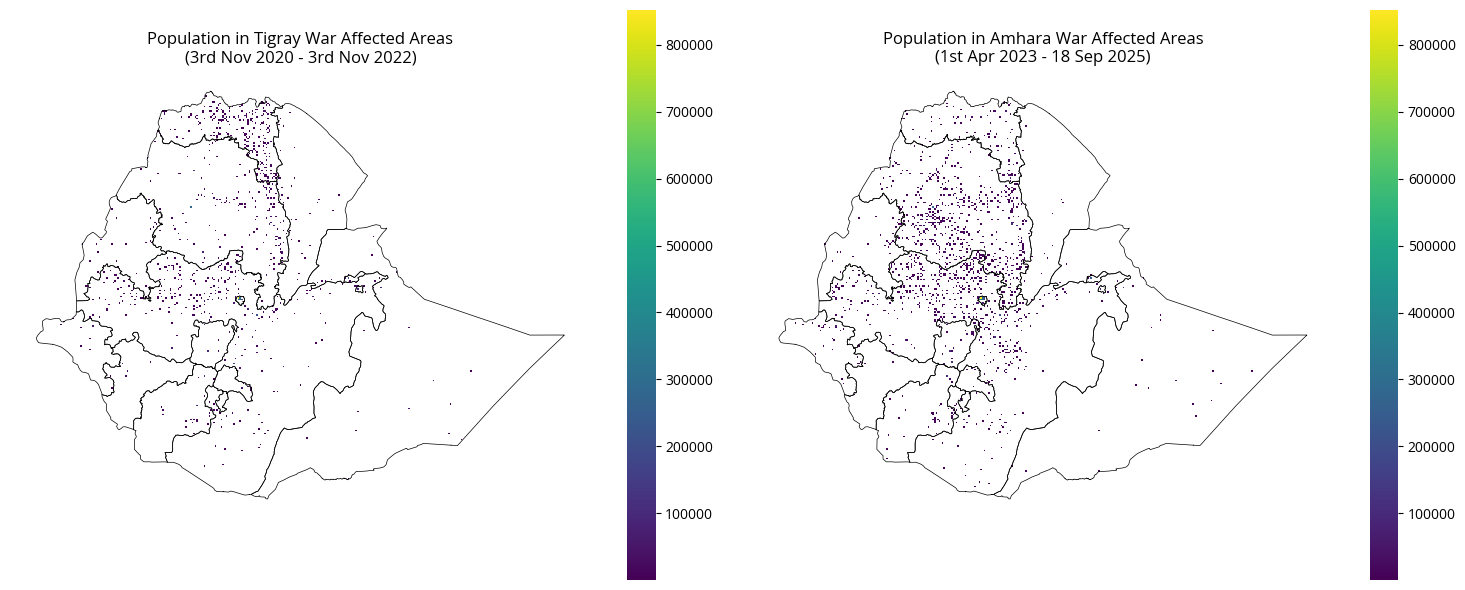

Total population in Tigray conflict areas: 12,078,380. This is 10.51% of Ethiopia's total population of 114,948,337.
Total population in Amhara conflict areas: 16,269,225. This is 14.15% of Ethiopia's total population of 114,948,337.
Average population density in Tigray areas: 15,328
Average population density in Amhara areas: 12,159


In [94]:
import matplotlib.pyplot as plt

# Create subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Tigray conflict affected areas with population data
tigray_pop = eth_worldpop[eth_worldpop['index'].isin(affected_quad_tigray)]
tigray_pop.plot(column='population', legend=True, ax=ax1)
#tigray_pop.plot(ax=ax1, column='population', cmap='Reds', legend=True, vmin=0, vmax=1000)
ax1.set_title('Population in Tigray War Affected Areas\n(3rd Nov 2020 - 3rd Nov 2022)', fontsize=12)
ethiopia_adm1.boundary.plot(ax=ax1, color='black', linewidth=0.5)
ax1.set_axis_off()

# Plot Amhara conflict affected areas with population data
amhara_pop = eth_worldpop[eth_worldpop['index'].isin(affected_quad_amhara)]
amhara_pop.plot(ax=ax2, column='population', legend=True)
ax2.set_title(f'Population in Amhara War Affected Areas\n(1st Apr 2023 - {last_date})', fontsize=12)
ethiopia_adm1.boundary.plot(ax=ax2, color='black', linewidth=0.5)
ax2.set_axis_off()

plt.tight_layout()
plt.show()

# # Print summary statistics
print(f"Total population in Tigray conflict areas: {tigray_pop['population'].sum():,.0f}. This is {100*tigray_pop['population'].sum()/total_population:.2f}% of Ethiopia's total population of {total_population:,.0f}.")
print(f"Total population in Amhara conflict areas: {amhara_pop['population'].sum():,.0f}. This is {100*amhara_pop['population'].sum()/total_population:.2f}% of Ethiopia's total population of {total_population:,.0f}.")
print(f"Average population density in Tigray areas: {tigray_pop['population'].mean():,.0f}")
print(f"Average population density in Amhara areas: {amhara_pop['population'].mean():,.0f}")